In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
import pickle
import plotly.express as px
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:.2f}'.format
import neurokit2 as nk
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 6)
import os, re
from importlib import reload
import empatica_helpers as eh
import helpers as h
import heartpy as hp

# eh.move_folders_to_root('input/empatica/')
# eh.rename_folders('input/empatica/')

dir_list = h.get_dir_list('input/empatica/')

# Combining, upsampling, trimming raw data for EDA, BVP, TEMP and ACC

In [3]:
reload(h), reload(eh)

df = pd.DataFrame() 
trimmings_array = np.array([]) # Trimmings are the numbers of samples removed from dataframes coming from a single folder due to differing start or end times. 
uniqueness_check_df = pd.DataFrame()

for folder in dir_list:
    temp, ibi, trimmings, uniqueness_check = eh.load_data_and_combine(f'input/empatica/{folder}', verbose = False)
    # Concat to df if not empty
    if temp.empty:
        print(f"Skipping {folder} due to empty dataframe.")
        continue
    trimmings_array = np.append(trimmings_array, trimmings)
    df = pd.concat([df, temp])
    uniqueness_check_df = pd.concat([uniqueness_check_df, uniqueness_check])

NameError: name 'ibi_df' is not defined

In [83]:
import os
import shutil
import re
import pandas as pd
import numpy as np
import neurokit2 as nk
from datetime import datetime, timedelta

from zmq import has

def move_folders_to_root(root_path, current_path=None):
    """
    This function deletes the .DS_Store file, recursively searches through all the folders and subfolders, and moves
    folders with no subfolders to the root directory. Empty folders are deleted.
    
    Args:
        root_path (str): The root path where the parent folders are located.
        current_path (str, optional): The current path being processed (used for recursion). Defaults to None.
    
    Returns:
        None
    """
    if current_path is None:
        current_path = root_path

        # Check if the root_path already contains only files and no folders
        items_in_root = [os.path.join(root_path, item) for item in os.listdir(root_path)]
        if all(os.path.isfile(item) for item in items_in_root):
            return
        
    # Remove the .DS_Store file if it exists
    ds_store_path = os.path.join(current_path, '.DS_Store')
    if os.path.exists(ds_store_path):
        os.remove(ds_store_path)

    subfolders = [os.path.join(current_path, item) for item in os.listdir(current_path) if os.path.isdir(os.path.join(current_path, item))]
    
    if not subfolders:
        # Base case: no subfolders
        if current_path != root_path:
            # Move the folder to the root directory
            shutil.move(current_path, get_unique_path(os.path.join(root_path, os.path.basename(current_path))))
    else:
        # Recursively process subfolders
        for subfolder in subfolders:
            move_folders_to_root(root_path, subfolder)

        # Remove empty folders
        if not os.listdir(current_path) and current_path != root_path:
            os.rmdir(current_path)

def get_unique_path(path):
    """
    This function generates a unique path if the given path already exists.
    
    :param path: The path to check for uniqueness.
    :return: A unique path.
    """

    counter = 1
    unique_path = path
    while os.path.exists(unique_path):
        unique_path = f"{path}_{counter}"
        counter += 1
    return unique_path

def clean_folder_name(folder_name):
    """
    Cleans the folder name by removing the trailing '_<number>' or '-<number>'.
    If no trailing number is found, the function returns False.

    Args:
    folder_name (str): The name of the folder to be cleaned.

    Returns:
    str or bool: The cleaned folder name, or False if no trailing number is found.
    """
    # Remove the trailing '_<number>' or '-<number>'
    cleaned_name = re.sub(r'[_-](\d+)$', '', folder_name)
    
    # Check if a trailing number was found and removed
    if cleaned_name == folder_name:
        return False
    
    return cleaned_name

def rename_folders(parent_folder):
    """
    Renames all folders within the specified parent folder.

    Args:
        parent_folder (str): The path to the parent folder.

    Returns:
        None
    """
    for item in os.listdir(parent_folder):
        item_path = os.path.join(parent_folder, item)

        # Check if it's a folder
        if os.path.isdir(item_path):
            original_name = item

            cleaned_name = original_name
            previous_cleaned_name = original_name

            while cleaned_name:
                # Clean folder name
                cleaned_name = clean_folder_name(cleaned_name)

                # If there is nothing to clean, break
                if cleaned_name is False:
                    cleaned_name = previous_cleaned_name
                    break

                # Find clean folder name path
                cleaned_path = os.path.join(parent_folder, cleaned_name)

                # If cleaned_path is not unique, set cleaned_name to previous_cleaned_name and break
                if os.path.exists(cleaned_path):
                    cleaned_name = previous_cleaned_name
                    break
                else:
                    previous_cleaned_name = cleaned_name

            cleaned_path = os.path.join(parent_folder, cleaned_name)
            # Rename the folder
            print(f"{original_name} -> {cleaned_name}")
            os.rename(item_path, cleaned_path)

def load_csv_file(file_path):
    df = pd.read_csv(file_path, header=None)
    starting_time = df.iloc[0, 0]
    sampling_rate = int(df.iloc[1, 0])
    signal = df.iloc[2:, :].values
    return starting_time, sampling_rate, signal

def handle_ibi_file(file_path):
    try:
        df = pd.read_csv(file_path, header=None)
    except pd.errors.EmptyDataError:
        print(f"Skipping {file_path} because it is empty.")
        return pd.DataFrame(), None, None

    if df.shape[0] < 2:
        print(f"Skipping {file_path} due to insufficient signal length.")
        return pd.DataFrame(), None, None
    
    ibi_df = pd.DataFrame(columns=['ibi', 'delta_t', 'datetime', 'unix_time', 'source'])
    ibi_df['ibi'] = df.iloc[1:, 1]
    ibi_df['delta_t'] = df.iloc[1:, 0]

    starting_time = df.iloc[0, 0].astype(int)
    ending_time = starting_time + ibi_df['delta_t'].sum()

    starting_datetime = datetime.fromtimestamp(starting_time)
    ibi_df['datetime'] = [starting_datetime + timedelta(seconds=delta_t) for delta_t in ibi_df['delta_t']]
    ibi_df['unix_time'] = starting_time + ibi_df['delta_t']

    ibi_df.drop(columns='delta_t', inplace=True)
    file = folder.split('/')[-1]
    ibi_df['source'] = file

    return ibi_df, starting_time, ending_time

def handle_other_files(file_path, desired_sampling_rate):
    starting_time, sampling_rate, signal = load_csv_file(file_path)
    if signal.shape[0] < 3:
        print(f"Skipping {file_path} due to insufficient signal length.")
        return None, None, None
    signal_data = nk.signal_resample(signal, sampling_rate=sampling_rate, desired_sampling_rate=desired_sampling_rate, method="FFT")
    signal_data = pd.DataFrame(signal_data)
    ending_time = starting_time + signal_data.shape[0] / desired_sampling_rate
    return signal_data, starting_time, ending_time

def load_data_and_combine(folder, desired_sampling_rate=64, verbose=False, useIBI = False):
    has_ibi = False
    file_names_except_ibi = ['ACC.csv', 'TEMP.csv', 'EDA.csv', 'BVP.csv', 'HR.csv']
    data_frames = []
    uniqueness_check = pd.DataFrame(columns=['file_path', 'file_name', 'starting_time', 'ending_time'])
    starting_times = []
    ending_times = []

    for file_name in file_names_except_ibi:
        file_path = os.path.join(folder, file_name)
        data, starting_time, ending_time = handle_other_files(file_path, desired_sampling_rate)
        if data is None:
            continue
        if file_name == 'ACC.csv':  # Handle the ACC.csv file with 3 columns
            data.columns = ['acc_x', 'acc_y', 'acc_z']
        else:
            column_name = file_name.lower().replace('.csv', '')
            data.columns = [column_name]

        starting_times.append(starting_time)
        ending_times.append(ending_time)
        data_frames.append(data)
    
    ibi_df, starting_time, ending_time = handle_ibi_file(os.path.join(folder, 'IBI.csv'))
    if useIBI is True and not ibi_df.empty:
        starting_times.append(starting_time)
        ending_times.append(ending_time)
        has_ibi = True

    # Trim dataframes
    trimmed_data_frames, trimmed_ibi_df, latest_start_time, earliest_end_time = trim_dataframes(data_frames, ibi_df, starting_times, ending_times, sr=desired_sampling_rate, has_ibi=has_ibi)
    trimmings = max([df.shape[0] for df in data_frames]) - max([df.shape[0] for df in trimmed_data_frames]) # Number of samples trimmed

    if verbose:
        print(f"latest_start_time: {latest_start_time}, earliest_end_time: {earliest_end_time}.")
        print(f"Original longest dataframe length: {max([df.shape[0] for df in data_frames])}, Trimmed dataframe length: {max([df.shape[0] for df in trimmed_data_frames])}. Difference: {trimmings} samples.")
    
    reset_index_data_frames = [df.reset_index(drop=True) for df in trimmed_data_frames]

    concatenated_df = pd.concat(reset_index_data_frames, axis=1)

    # Add time column starting at latest_start_time and ending at earliest_end_time
    time_unix = np.arange(latest_start_time, earliest_end_time, 1 / desired_sampling_rate)
    datetime = pd.to_datetime(time_unix, unit='s', origin='unix')

    # Add time column to the concatenated_df
    concatenated_df['datetime'] = datetime
    concatenated_df['unix_time'] = time_unix

    # Distill file name from folder (e.g. "file" from "input/empatica/file")
    file = folder.split('/')[-1]
    
    concatenated_df['source'] = file
    ibi_df['source'] = file
    
    return concatenated_df, trimmed_ibi_df, trimmings, uniqueness_check

def trim_dataframes(data_frames, ibi_df, starting_times, ending_times, sr, has_ibi):
    latest_start_time = max(starting_times)
    earliest_end_time = min(ending_times)

    trimmed_data_frames = []
    for idx, df in enumerate(data_frames):
        start_idx = int((latest_start_time - starting_times[idx]) * sr)
        end_idx = int((earliest_end_time - starting_times[idx]) * sr)
        df_trimmed = df.iloc[start_idx:end_idx, :]
        trimmed_data_frames.append(df_trimmed)

    # Trim ibi_df
    if has_ibi:
        trimmed_ibi_df = ibi_df[(ibi_df['unix_time'] >= latest_start_time) & (ibi_df['unix_time'] <= earliest_end_time)]
    else:
        trimmed_ibi_df = None
        
    return trimmed_data_frames, trimmed_ibi_df, latest_start_time, earliest_end_time



In [84]:
reload(h), reload(eh)

df = pd.DataFrame() 
ibi_df = pd.DataFrame()
trimmings_array = np.array([]) # Trimmings are the numbers of samples removed from dataframes coming from a single folder due to differing start or end times. 
uniqueness_check_df = pd.DataFrame()
no_ibi = 0
for folder in dir_list:
    temp, ibi, trimmings, uniqueness_check = load_data_and_combine(f'input/empatica/{folder}', verbose = False, useIBI = True)
    # Concat to df if not empty
    if not temp.empty:
        trimmings_array = np.append(trimmings_array, trimmings)
        df = pd.concat([df, temp])
        uniqueness_check_df = pd.concat([uniqueness_check_df, uniqueness_check])
        ibi_df = pd.concat([ibi_df, ibi])
    else:
        print(f"Skipping {folder} due to empty dataframe.")
    if ibi is None:
        no_ibi += 1

print(f"Number of folders with no IBI data: {no_ibi} / {len(dir_list)}")

Skipping input/empatica/pp7-d2-4/IBI.csv because it is empty.
Skipping input/empatica/pp5-d1-1/IBI.csv because it is empty.
Skipping input/empatica/pp7-d2-5/IBI.csv because it is empty.
Skipping input/empatica/pp4-d2_1_1/HR.csv due to insufficient signal length.
Skipping input/empatica/pp4-d2_1_1/IBI.csv because it is empty.
Skipping input/empatica/pp3-d1-1/IBI.csv because it is empty.
Skipping input/empatica/pp7-d1-2/IBI.csv because it is empty.
Skipping input/empatica/pp4-d2_1/IBI.csv because it is empty.
Skipping input/empatica/pp5-d2-1/IBI.csv because it is empty.
Skipping input/empatica/pp5-d2-6/IBI.csv because it is empty.
Skipping input/empatica/pp4-d2-9/IBI.csv because it is empty.
Skipping input/empatica/pp4-d2-7/IBI.csv because it is empty.
Skipping input/empatica/pp3-d2-5/HR.csv due to insufficient signal length.
Skipping input/empatica/pp3-d2-5/IBI.csv because it is empty.
Skipping input/empatica/pp7-d2-7/IBI.csv because it is empty.
Skipping input/empatica/pp7-d2-6/IBI.csv

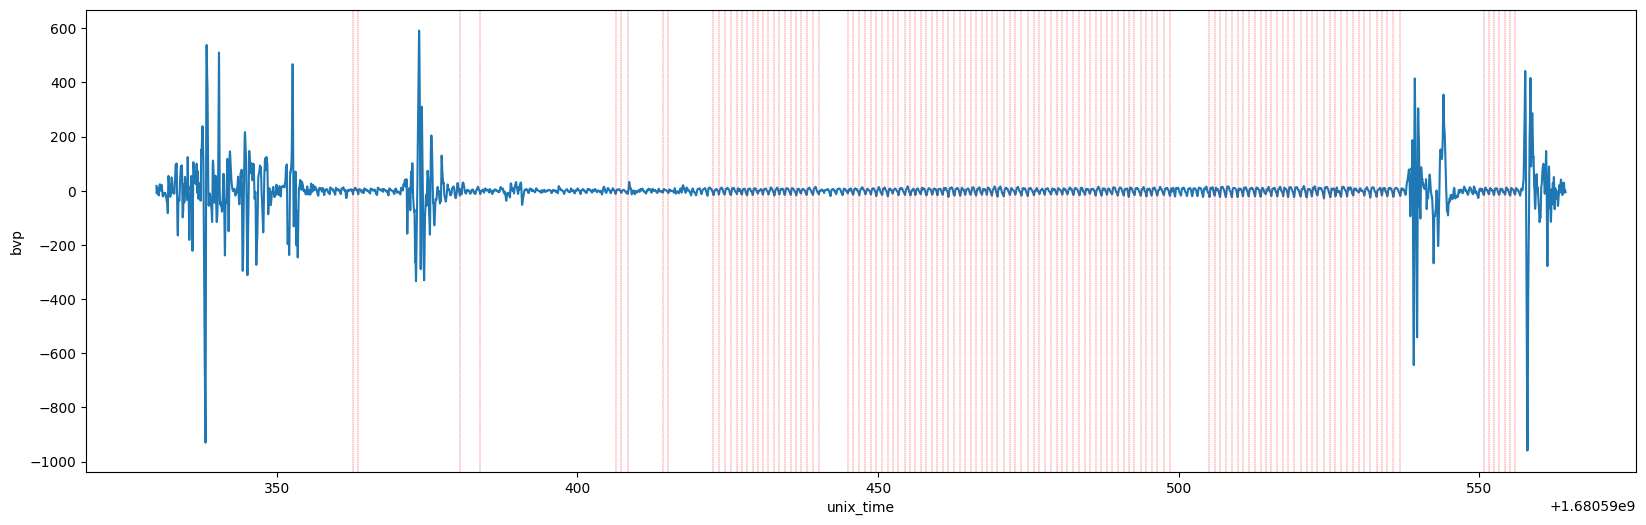

In [95]:
# Plot df['bvp'] and add vertical lines as markers for each value in df_ibi['unix_time'] using sns
fig, ax = plt.subplots()
sns.lineplot(data=df.iloc[0:15000], x='unix_time', y='bvp', ax=ax)

# Get the 'unix_time' of the 10000th sample in df
start_time = df.iloc[0]['unix_time']
end_time = df.iloc[14999]['unix_time']

# Iterate over ibi_df until 'unix_time' reaches end_time
for idx, row in ibi_df.iterrows():
    if row['unix_time'] > end_time:
        break
    if row['unix_time'] >= start_time:
        plt.axvline(row['unix_time'], color='r', linestyle='--', alpha=1, linewidth=0.3)

plt.show()

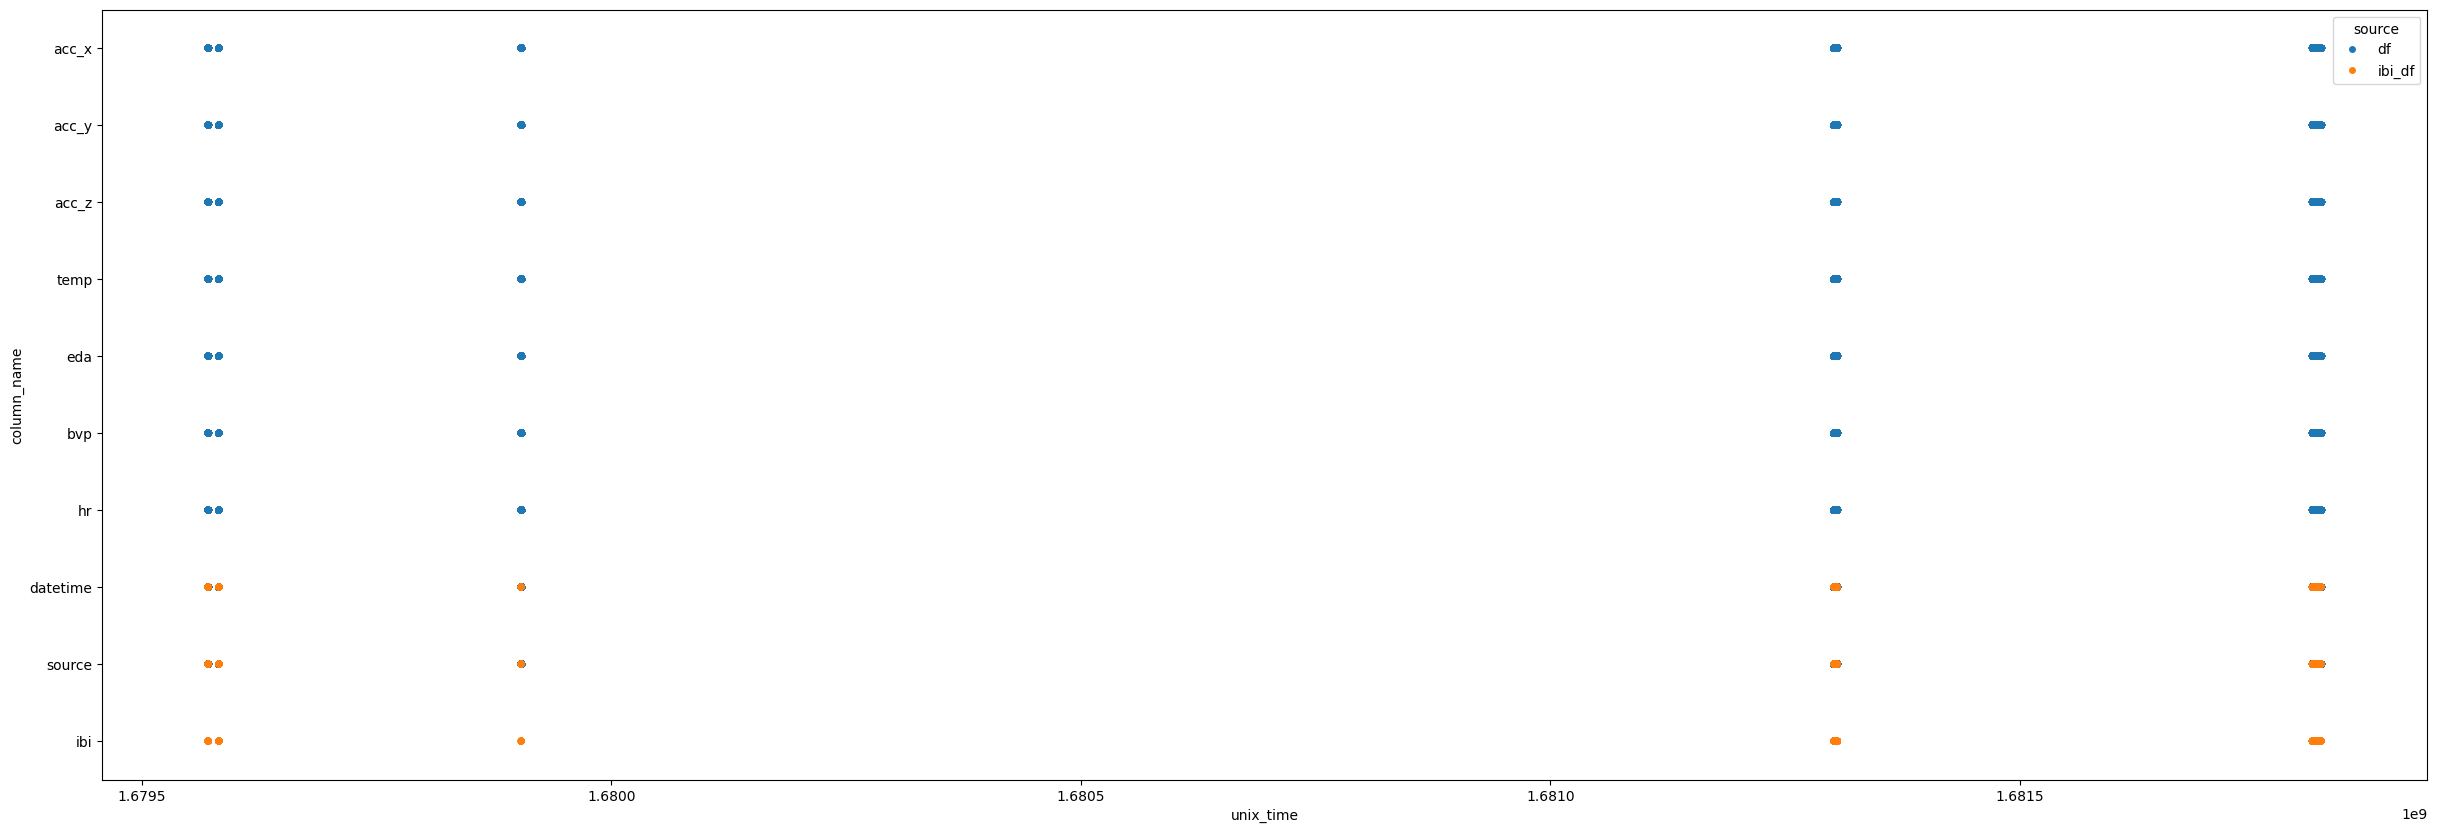

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt df
df_melted = df.melt(id_vars='unix_time', var_name='column_name')

# Melt ibi_df
ibi_df_melted = ibi_df.melt(id_vars='unix_time', var_name='column_name')

# Add a 'source' column to distinguish between the two DataFrames
df_melted['source'] = 'df'
ibi_df_melted['source'] = 'ibi_df'

# Concatenate the two melted DataFrames
combined_melted = pd.concat([df_melted, ibi_df_melted])

# Plot
plt.figure(figsize=(30, 10))
sns.stripplot(x='unix_time', y='column_name', hue='source', data=combined_melted, jitter=False)
plt.show()

# Data cleaning

## Dataframe trimming

### Number of trimmed samples

[]


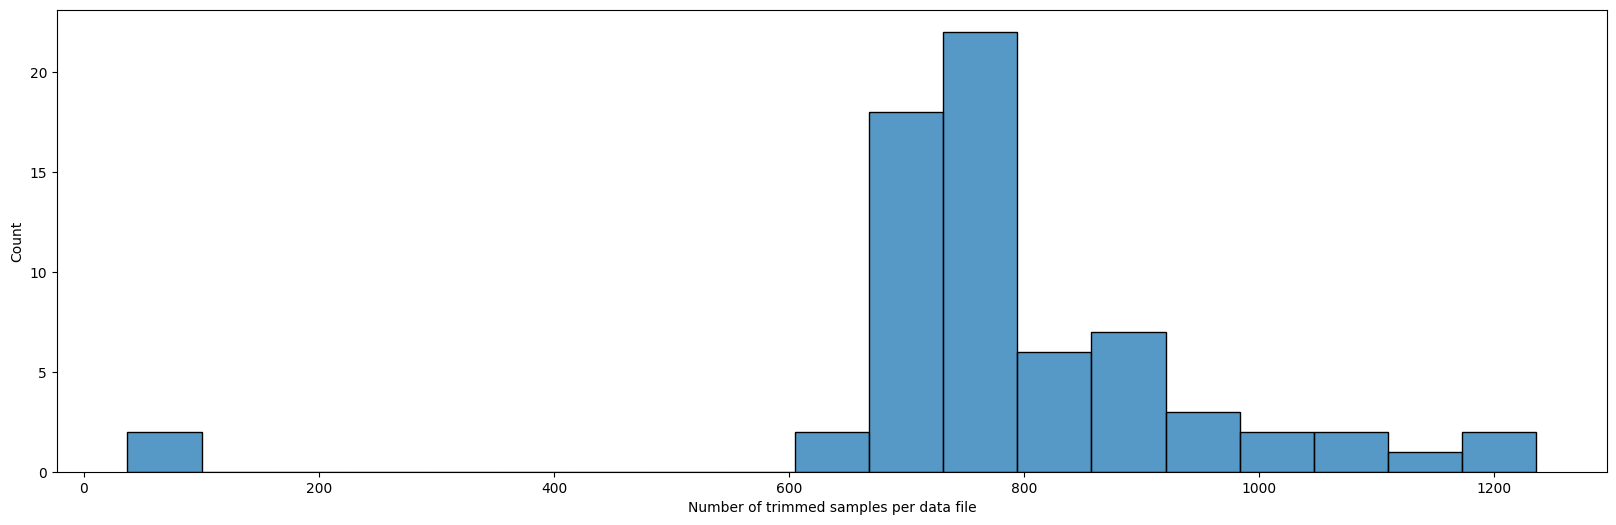

In [96]:
# Seaborn kernel density plot
sns.histplot(data=trimmings_array, fill=True)
plt.xlabel("Number of trimmed samples per data file")
# output/trimmed_samples.png

# Check values in trimmings_array < 0
print(trimmings_array[trimmings_array < 0])

### Aligning of data sources

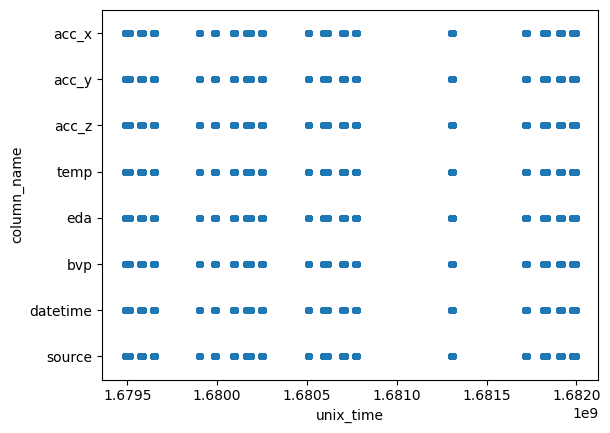

<Figure size 3000x1000 with 0 Axes>

In [3]:
# chunk_size = 100000  # Adjust this value based on your available memory
# chunks = [x for x in range(0, df.shape[0], chunk_size)]

# df_melted = pd.DataFrame()

# for i in range(len(chunks) - 1):
#     df_chunk = df.iloc[chunks[i]:chunks[i + 1]]
#     df_melted_chunk = df_chunk.melt(id_vars='unix_time', var_name='column_name')
#     df_melted = pd.concat([df_melted, df_melted_chunk])

# # Last chunk
# df_chunk = df.iloc[chunks[-1]:]
# df_melted_chunk = df_chunk.melt(id_vars='unix_time', var_name='column_name')
# df_melted = pd.concat([df_melted, df_melted_chunk])

# # Store df_melted as pickle
# with open('output/empatica_melted.pkl', 'wb') as f:
#     pickle.dump(df_melted, f)

# Load df_melted from pickle
with open('output/empatica_melted.pkl', 'rb') as f:
    df_melted = pickle.load(f)

sns.stripplot(x='unix_time', y='column_name', data=df_melted, jitter=False)
plt.figure(figsize=(30, 10))
plt.show()
# output/data_source_alignment.png

## Statistical properties

In [98]:
df['source'] = df['source'].astype(str)
print(df.info())
print(df.describe())

print(ibi_df.info())
print(ibi_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 12413182 entries, 0 to 94719
Data columns (total 10 columns):
 #   Column     Dtype         
---  ------     -----         
 0   acc_x      float64       
 1   acc_y      float64       
 2   acc_z      float64       
 3   temp       float64       
 4   eda        float64       
 5   bvp        float64       
 6   hr         float64       
 7   datetime   datetime64[ns]
 8   unix_time  float64       
 9   source     object        
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 1.0+ GB
None
            acc_x       acc_y       acc_z        temp         eda         bvp  \
count 12413182.00 12413182.00 12413182.00 12413182.00 12413182.00 12413182.00   
mean       -12.07        2.32       49.22       30.22        0.89       -0.00   
min       -174.29     -147.62     -165.11       20.12       -0.27    -2198.92   
25%        -37.04       -3.94       45.54       28.39        0.27      -17.02   
50%        -17.62        1.00       56.0

## Uniqueness

- No duplicate files.

In [8]:
print(uniqueness_check_df[uniqueness_check_df.duplicated(subset=['file_name', 'starting_time', 'ending_time'], keep=False)])

Empty DataFrame
Columns: [file_path, file_name, starting_time, ending_time]
Index: []


## Missing data

- No missing data

In [99]:
# Check for missing data in df
print(df.isnull().sum())

acc_x          0
acc_y          0
acc_z          0
temp           0
eda            0
bvp            0
hr           576
datetime       0
unix_time      0
source         0
dtype: int64


In [101]:
df.to_csv('output/empatica_raw.csv', index=False)
ibi_df.to_csv('output/empatica_ibi.csv', index=False)

---
😎 **CHECKPOINT**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import signal
import pickle
import plotly.express as px
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:.2f}'.format
import neurokit2 as nk
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 6)
import os, re
from importlib import reload
import empatica_helpers as eh
import helpers as h
import heartpy as hp

# eh.move_folders_to_root('input/empatica/')
# eh.rename_folders('input/empatica/')

dir_list = h.get_dir_list('input/empatica/')

df = pd.read_csv('output/empatica_raw.csv')
ibi_df = pd.read_csv('output/empatica_ibi.csv')
df.head()
len(df)

/var/folders/4y/grqbq6j10592pmzzhgzbxdmr0000gn/T/ipykernel_79918/2347266024.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


12413182

## PPG Filtering

Src: [Goda, M. A., Charlton, P. H., & Behar, J. A. (2023). pyPPG: A Python toolbox for comprehensive photoplethysmography signal analysis. DOI 10.1088/1361-6579/ad33a2](https://iopscience.iop.org/article/10.1088/1361-6579/ad33a2)

- **Bandpass filtering between 0.5-12 Hz**: A fourth-order Chebyshev Type II filter was used for the original signal. The 12 Hz low-pass cut-off was used to avoid time-shifting of fiducial points (particularly pulse onset, and dicrotic notch) and to eliminate unwanted high-frequency content from the PPG derivatives. The 0.5 Hz high-pass cut-off was used to minimize baseline wandering whilst retaining content at low heart rates.
- **50 ms moving average filtering (MAF)**: In the case of very noisy signals, some high-frequency content can remain in the band-pass filter signal. For this purpose, a 50 ms standard flat (boxcar or top-hat) MAF with a 9 Hz cut-off frequency was applied after the band-pass filtering.

In [2]:
sampling_rate = 64
ppg = df['bvp']
ppg_clean = nk.ppg_clean(ppg, sampling_rate) # Elgendi, M., Norton, I., Brearley, M., Abbott, D., & Schuurmans, D. (2013). Systolic peak detection in acceleration photoplethysmograms measured from emergency responders in tropical conditions. PloS one, 8(10), e76585.

ppg_df = pd.DataFrame({'ppg': ppg, 'ppg_clean': ppg_clean})
ppg_df = ppg_df.reset_index()

In [3]:
import numpy as np
import pandas as pd
from scipy import signal
import neurokit2 as nk

smoothing_window = 250 # in ms

# Bandpass filter
b, a = signal.cheby2(N=4, rs = 20, fs = 64, btype = 'bandpass', Wn = [0.5000001, 12]) # 0.5-12 Hz
ppg_bandpassed = signal.filtfilt(b, a, ppg_clean)
ppg_df['ppg_bandpassed'] = ppg_bandpassed

# Moving average
win = round(sampling_rate * smoothing_window/1000)
B = 1 / win * np.ones(win)
ppg_moving_average = signal.filtfilt(B, 1, ppg_bandpassed)
ppg_df['ppg_moving_average'] = ppg_moving_average

# Variable moving average
# Calculate standard deviation of the signal over a certain window
window_size = 250 # in ms
win = round(sampling_rate * window_size/1000)
var = ppg_df['ppg_bandpassed'].rolling(window=win, center=True).var()

# Scale standard deviation values to the range [50, 500]
min_win = 50
max_win = 500
var_scaled = ((var - var.min()) / (var.max() - var.min())).fillna(0)
var_scaled = var_scaled.fillna(0)

assert len(var_scaled) == len(ppg_df['ppg_bandpassed']), "Length of std_dev_scaled does not match length of ppg_bandpassed."

# Variable moving average
win_list = []
for i in range(len(ppg_df['ppg_bandpassed'])):
    win = int(var_scaled[i] * max_win)
    if win < min_win:
        win = min_win
    win_list.append(win)
B = [1 / win * np.ones(win) for win in win_list]


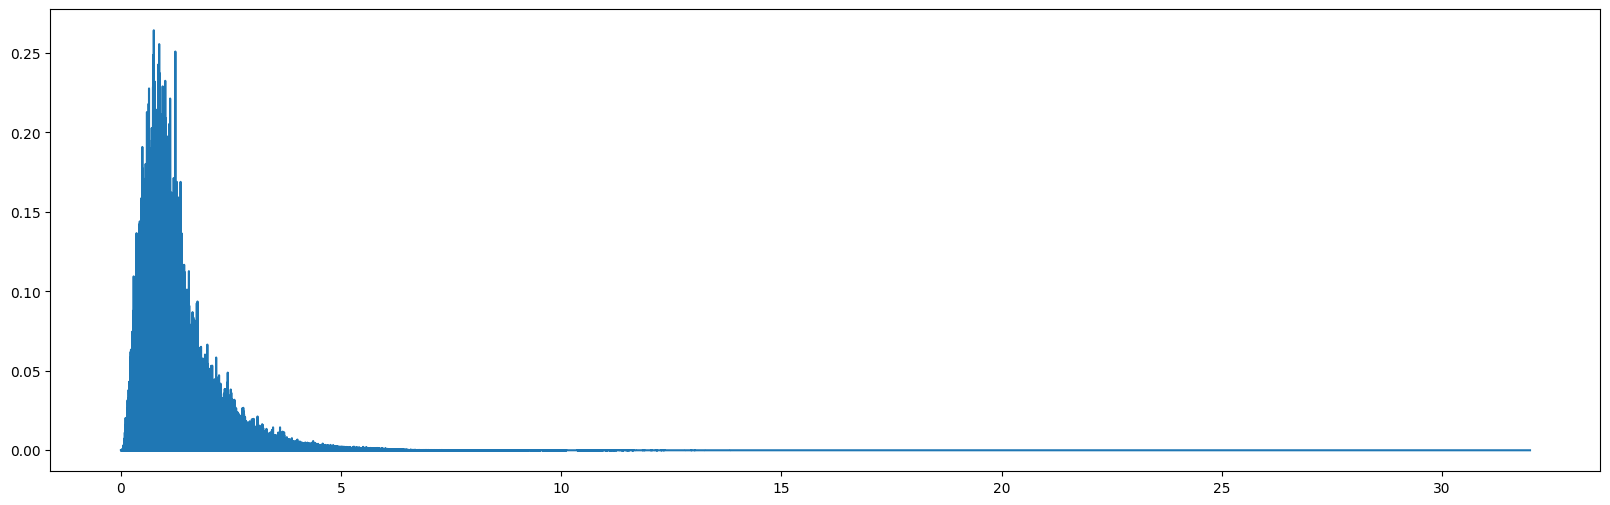

In [ ]:
# Apply FFT
ppg_fft = np.fft.fft(ppg_df['ppg'])

# Get absolute value of complex numbers
ppg_fft_abs = np.abs(ppg_fft)

# Get frequencies corresponding to the values in FFT
frequencies = np.fft.fftfreq(len(ppg_df['ppg']))

# Plot the FFT
plt.plot(frequencies, ppg_fft_abs)
plt.show()

In [ ]:
ppg_df['ppg_variable_moving_average'] = ppg_variable_moving_average

ValueError: Could not interpret value `ppg_moving_average` for `y`. An entry with this name does not appear in `data`.

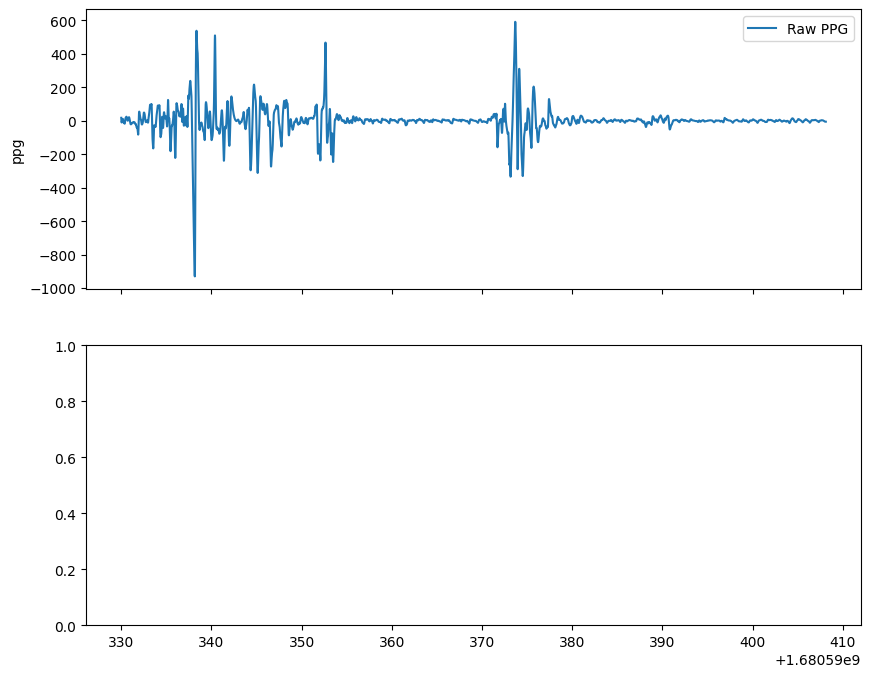

In [ ]:
fig, axs = plt.subplots(2, sharex=True, figsize=(10, 8))

# Plot timeseries of both raw and clean PPG using sns
sns.lineplot(data=ppg_df[0:5000], x=df['unix_time'][0:5000], y='ppg', ax=axs[0], label='Raw PPG')
sns.lineplot(data=ppg_df[0:5000], x=df['unix_time'][0:5000], y='ppg_variable_moving_average', ax=axs[0], label='Clean PPG')
axs[0].legend()
axs[0].set_title('Raw and Clean PPG')

# Add a plot that shares the same x-axis, showing df['acc_x'], df['acc_y'], and df['acc_z'] using sns
sns.lineplot(data=df[0:5000], x='unix_time', y='acc_x', ax=axs[1], label='acc_x')
sns.lineplot(data=df[0:5000], x='unix_time', y='acc_y', ax=axs[1], label='acc_y')
sns.lineplot(data=df[0:5000], x='unix_time', y='acc_z', ax=axs[1], label='acc_z')
axs[1].legend()
axs[1].set_title('Acceleration Data')

plt.tight_layout()
plt.show()

### Peak detection & artefact correction

#### NeuroKit2

207697

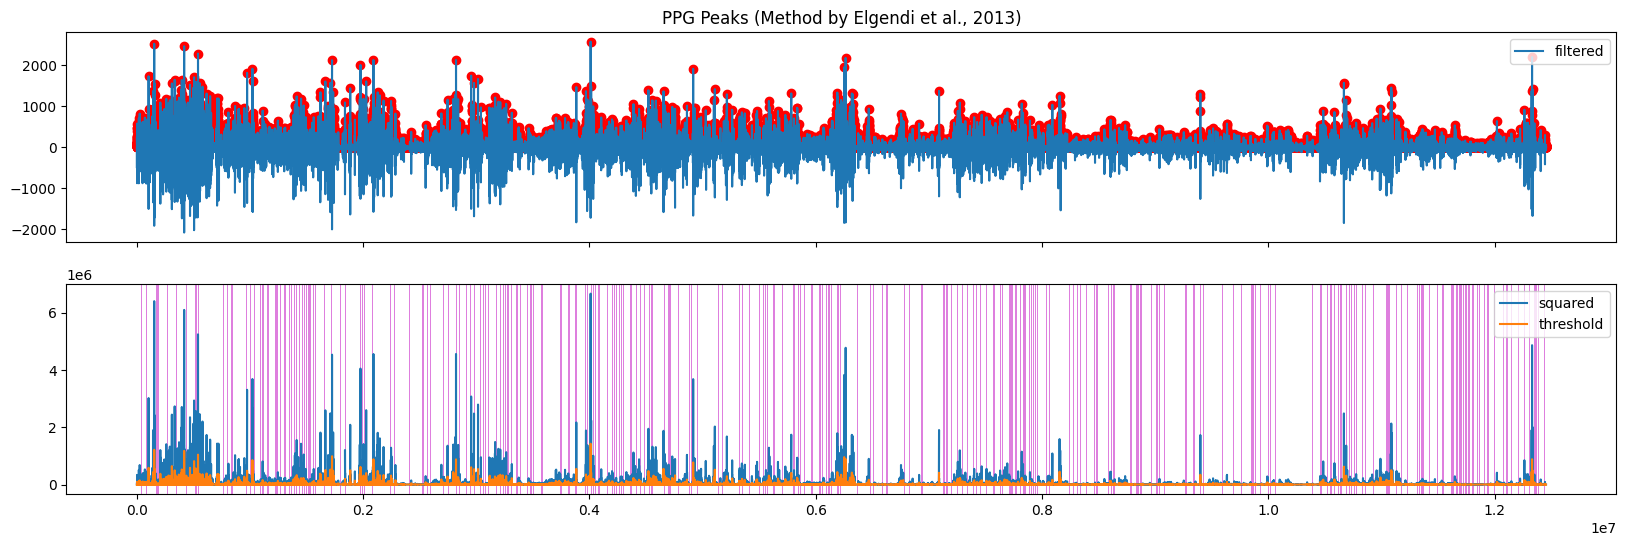

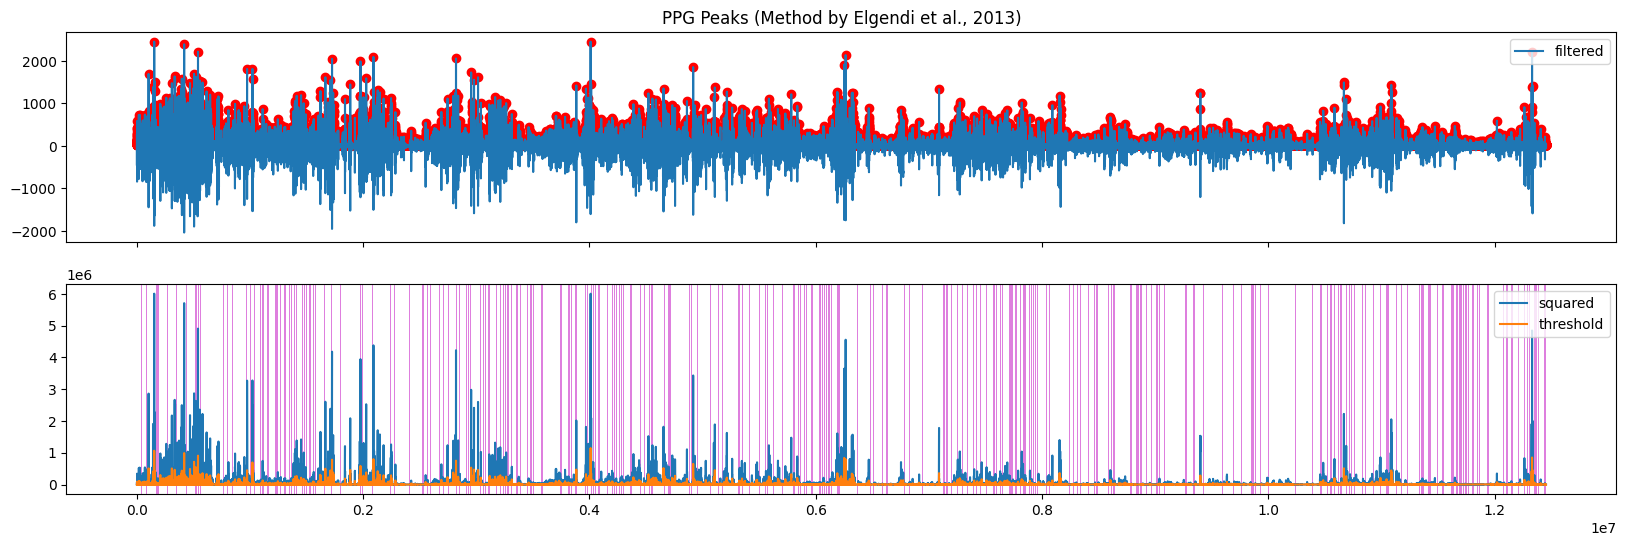

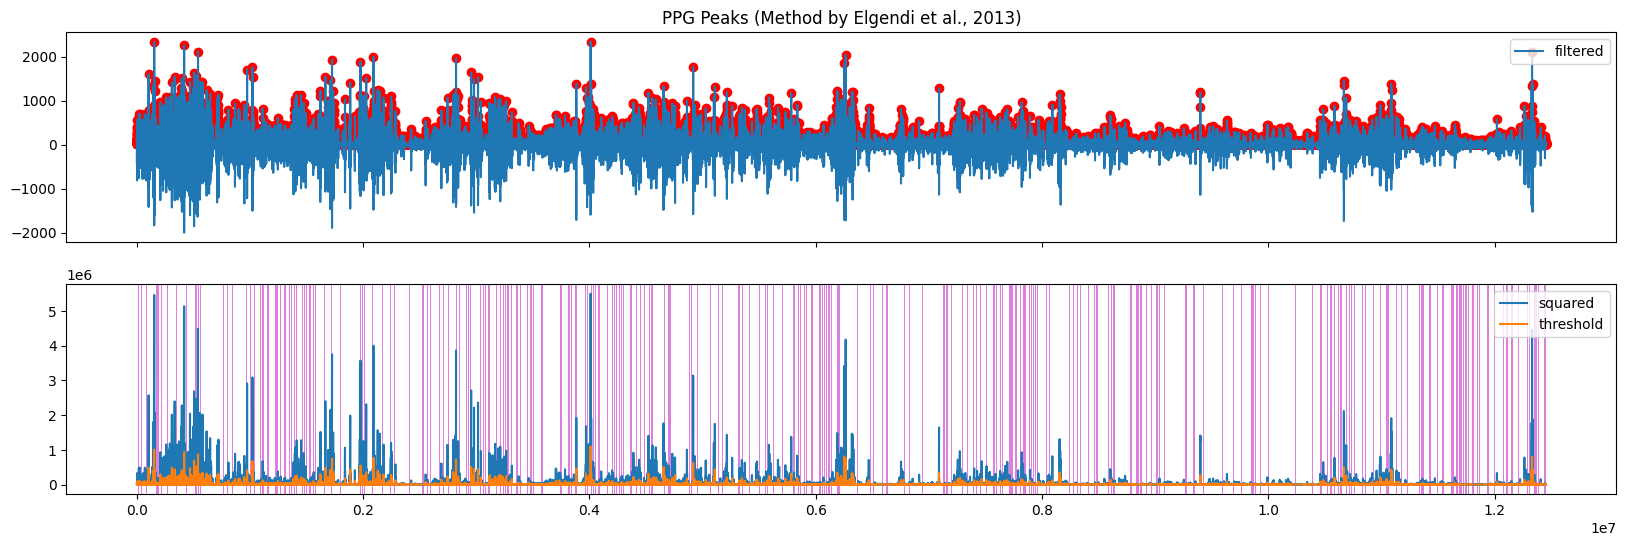

In [25]:
# ppg_clean
info_clean = nk.ppg_findpeaks(ppg_df['ppg_clean'], sampling_rate, show=True)
ppg_peaks_clean = info_clean['PPG_Peaks']

len(ppg_peaks_clean)
# output/nk_peaks_ppg_clean.png

# ppg_bandpassed
info_bandpassed = nk.ppg_findpeaks(ppg_df['ppg_bandpassed'], sampling_rate, show=True)
ppg_peaks_bandpassed = info_bandpassed['PPG_Peaks']

len(ppg_peaks_bandpassed)
# output/nk_peaks_ppg_bandpassed.png

# ppg_moving_average
info_moving_average = nk.ppg_findpeaks(ppg_df['ppg_moving_average'], sampling_rate, show=True)
ppg_peaks_moving_average = info_moving_average['PPG_Peaks']

len(ppg_peaks_moving_average)
# output/nk_peaks_ppg_moving_average.png

In [26]:
print(f"Number of peaks in ppg_clean: {len(ppg_peaks_clean)}")
print(f"Number of peaks in ppg_bandpassed: {len(ppg_peaks_bandpassed)}")
print(f"Number of peaks in ppg_moving_average: {len(ppg_peaks_moving_average)}")

Number of peaks in ppg_clean: 202056
Number of peaks in ppg_bandpassed: 208445
Number of peaks in ppg_moving_average: 207697


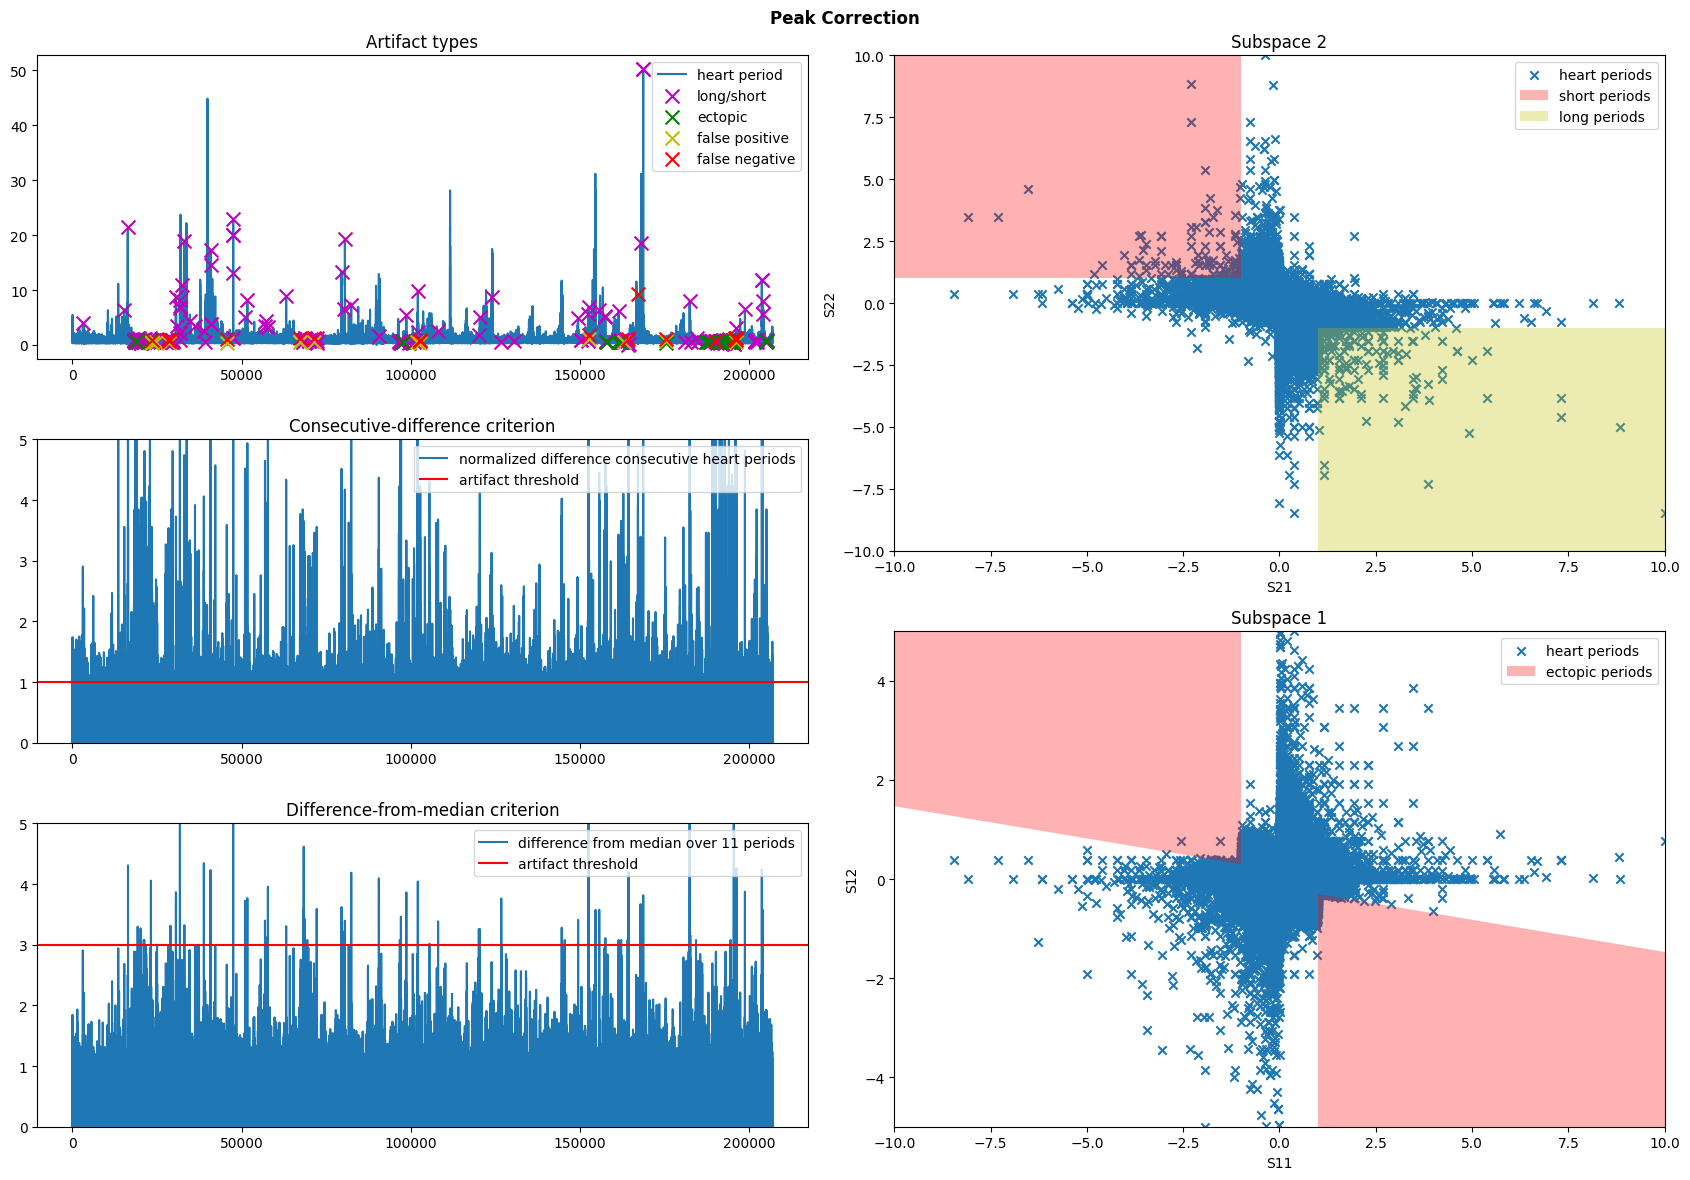

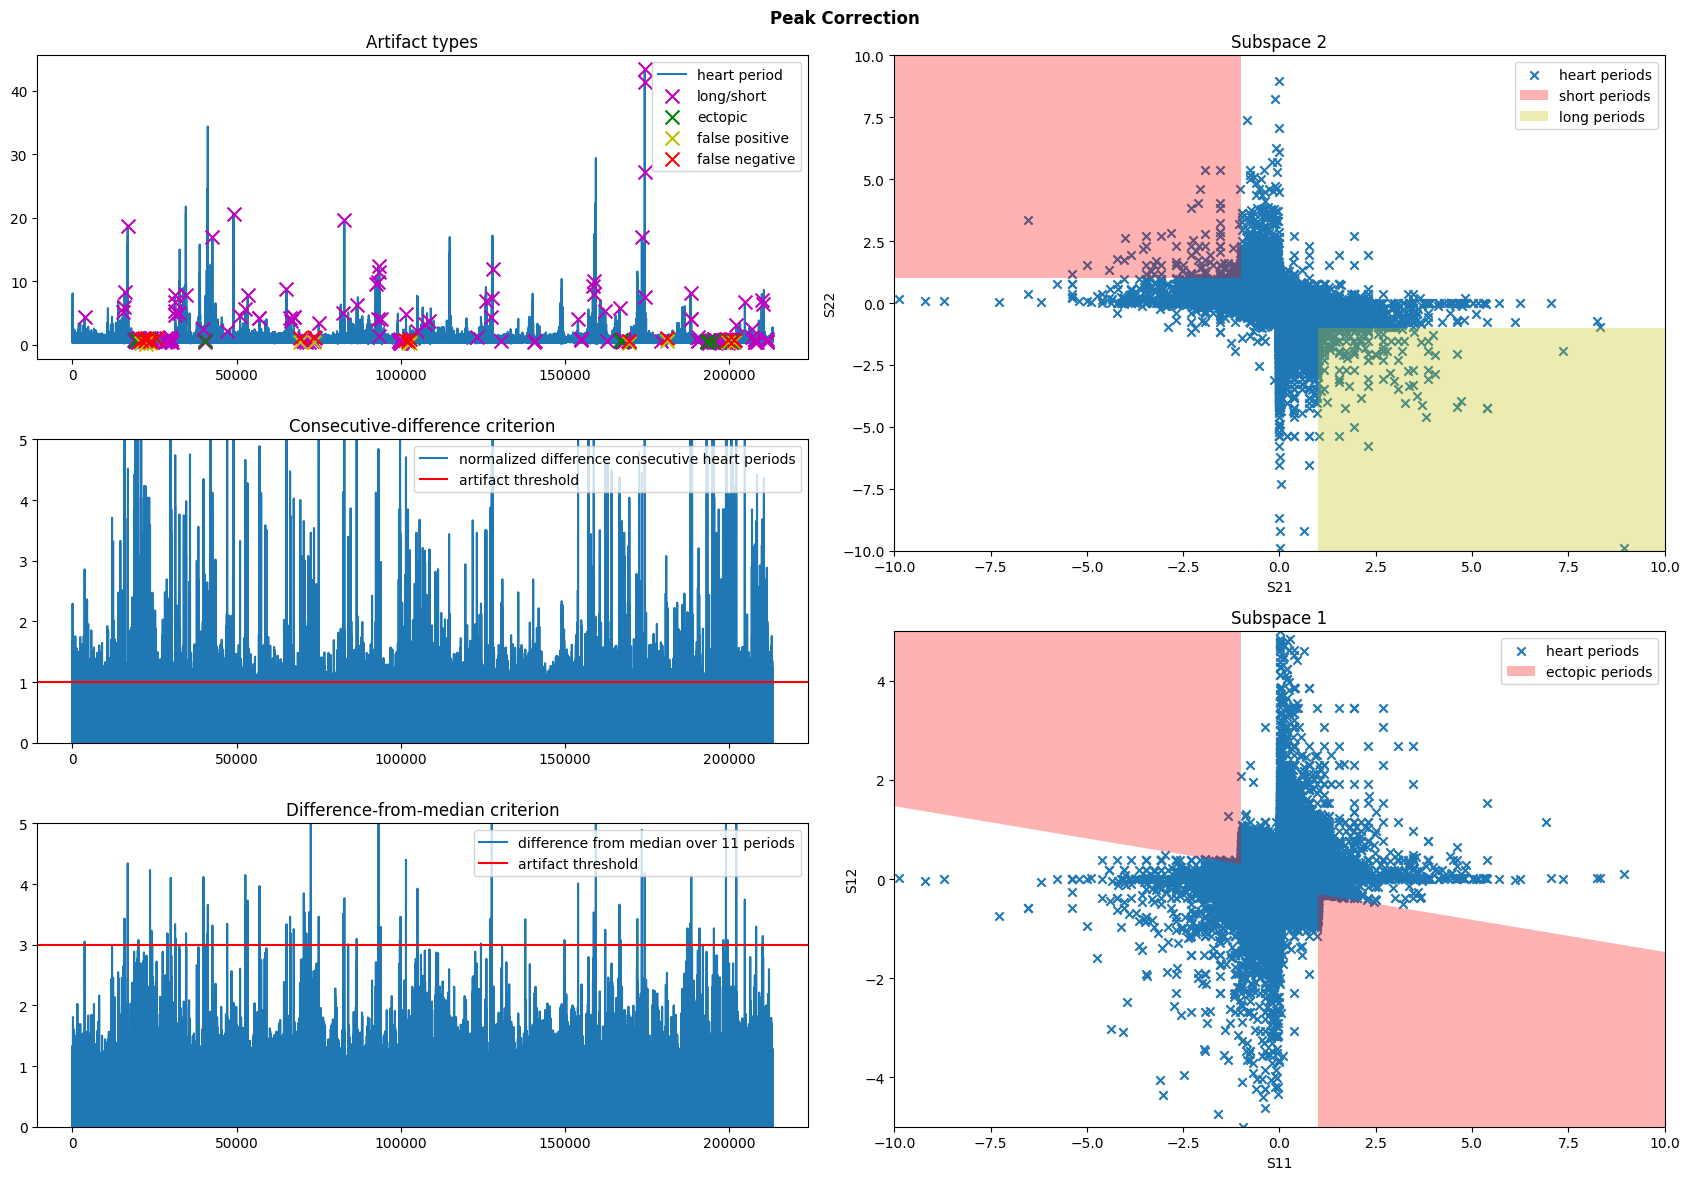

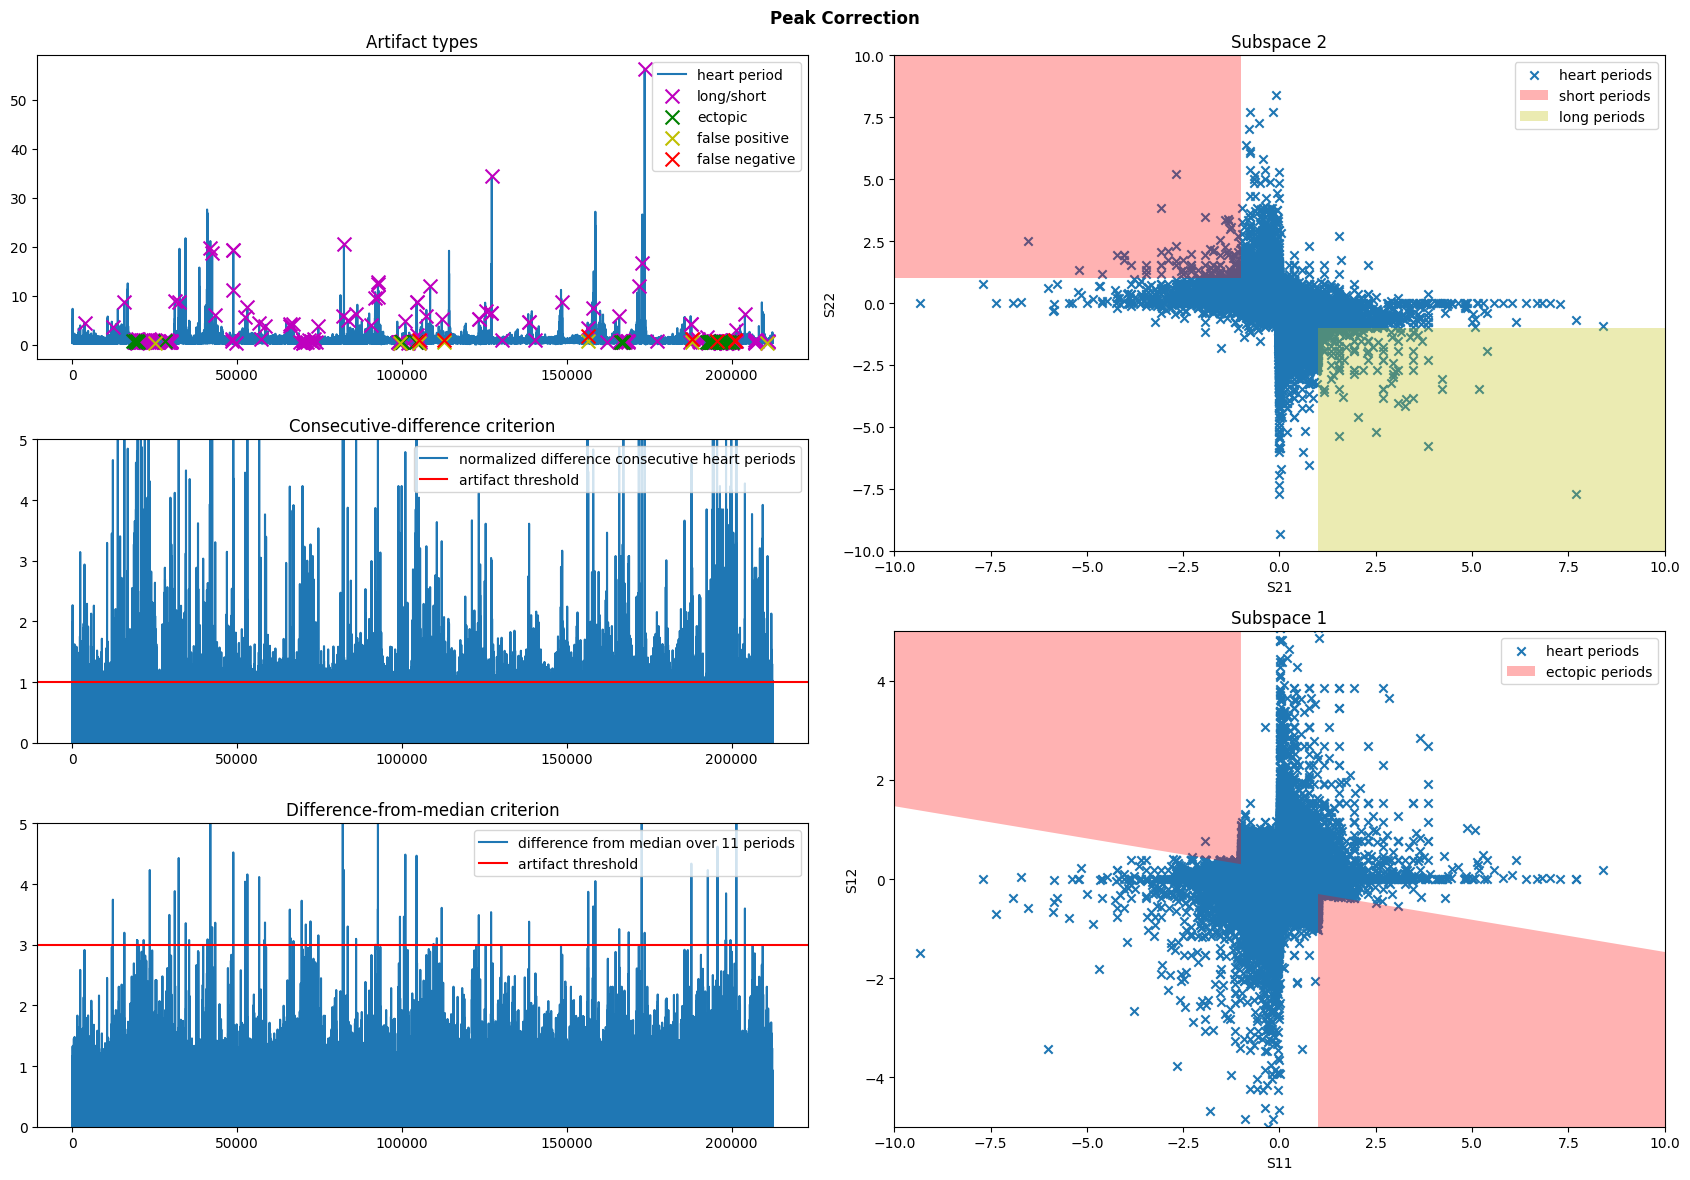

In [27]:
# Correct erroneous peak placements
artifacts_clean, ppg_peaks_clean_corrected = nk.signal_fixpeaks(ppg_peaks_clean, sampling_rate, iterative=True, show=True, method="Kubios") # Lipponen, J. A., & Tarvainen, M. P. (2019)

# output/artefact_correction_ppg_peaks_clean.png

artifacts_bandpassed, ppg_peaks_bandpassed_corrected = nk.signal_fixpeaks(ppg_peaks_bandpassed, sampling_rate, iterative=True, show=True, method="Kubios") # Lipponen, J. A., & Tarvainen, M. P. (2019)

# output/artefact_correction_ppg_peaks_bandpassed.png

artifacts_moving_average, ppg_peaks_moving_average_corrected = nk.signal_fixpeaks(ppg_peaks_moving_average, sampling_rate, iterative=True, show=True, method="Kubios") # Lipponen, J. A., & Tarvainen, M. P. (2019)

# output/artefact_correction_ppg_peaks_moving_average.png

{'clean': {'ectopic': 23, 'missed': 16, 'extra': 14, 'longshort': 300}, 'bandpassed': {'ectopic': 16, 'missed': 15, 'extra': 12, 'longshort': 274}, 'moving_average': {'ectopic': 31, 'missed': 7, 'extra': 7, 'longshort': 271}}


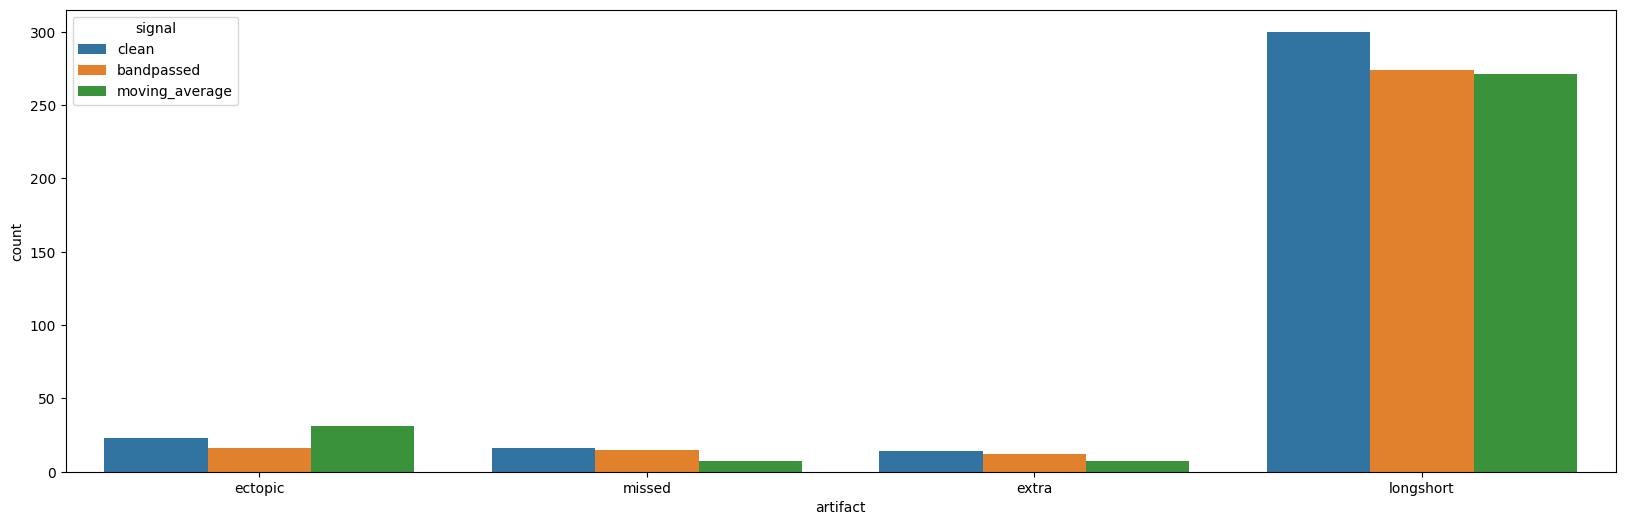

In [34]:
artifact_types = ['ectopic', 'missed', 'extra', 'longshort']

# Count the number of artifacts of each type in each of the three ppg signals
artifact_counts = {
    'clean': {artifact: len(artifacts_clean[artifact]) for artifact in artifact_types},
    'bandpassed': {artifact: len(artifacts_bandpassed[artifact]) for artifact in artifact_types},
    'moving_average': {artifact: len(artifacts_moving_average[artifact]) for artifact in artifact_types}
}

artifact_counts_df = pd.DataFrame(artifact_counts).reset_index().melt(id_vars='index', value_vars=['clean', 'bandpassed', 'moving_average'], var_name='signal', value_name='count')
artifact_counts_df['artifact'] = artifact_counts_df['index']
artifact_counts_df = artifact_counts_df.drop(columns='index')

sns.barplot(data=artifact_counts_df, x='artifact', y='count', hue='signal')
plt.show()


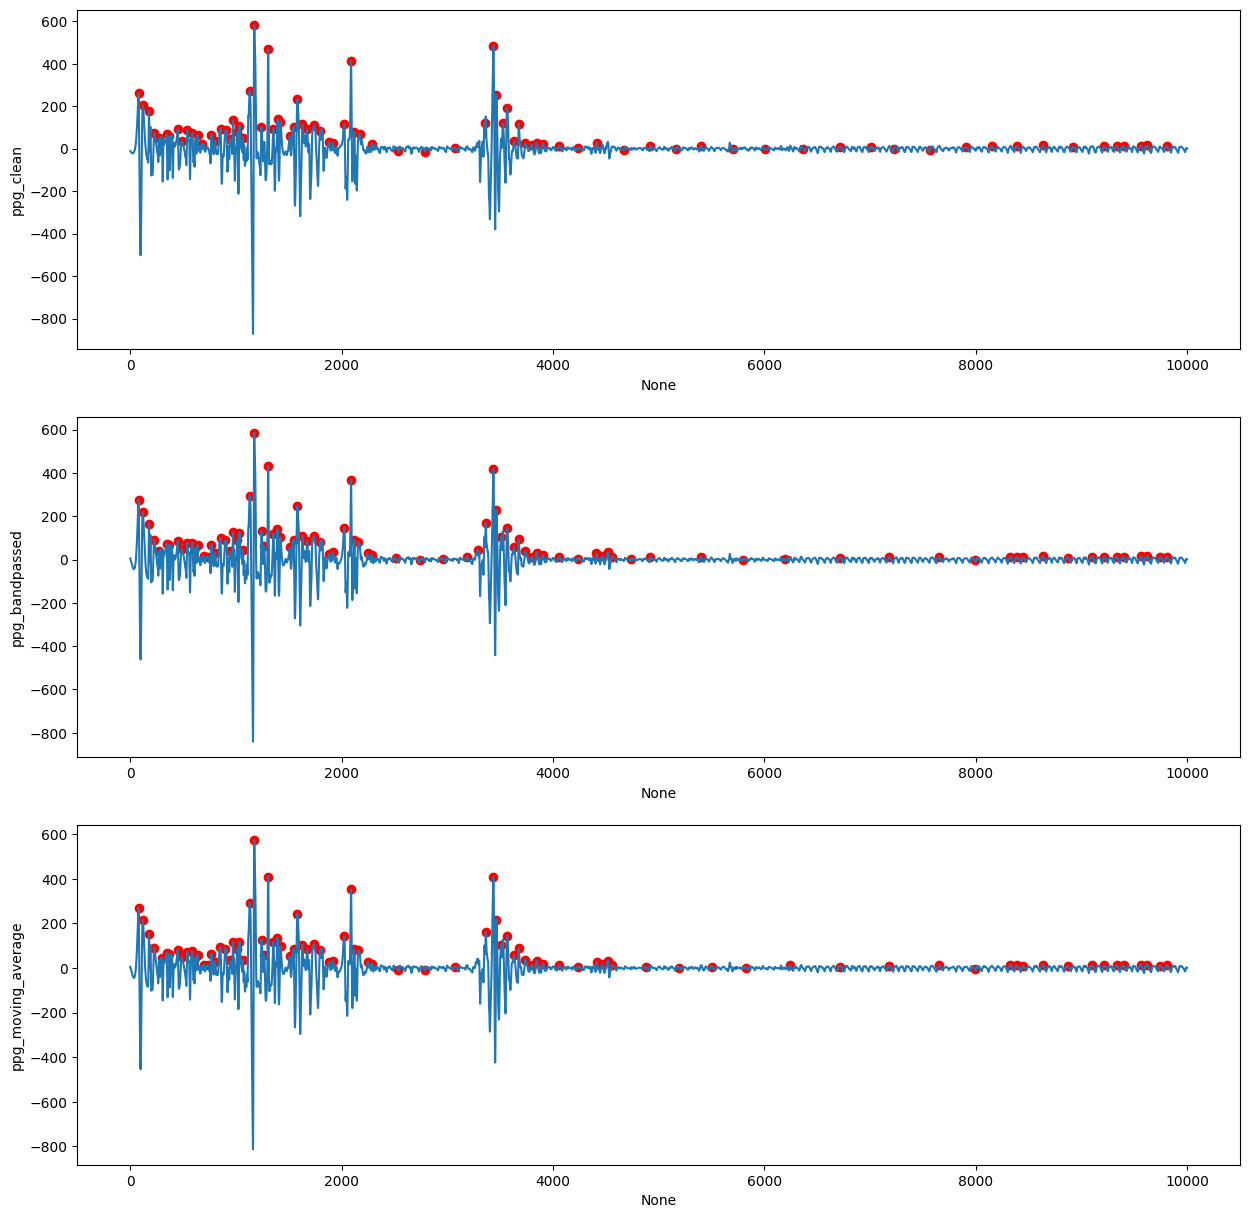

In [39]:
n = 10000
# Create full arrays of zeros with the same length as the 'ppg_clean', 'ppg_bandpassed', and 'ppg_moving_average' columns
ppg_peaks_binary_clean = np.zeros(len(ppg_df['ppg_clean']))
ppg_peaks_binary_bandpassed = np.zeros(len(ppg_df['ppg_bandpassed']))
ppg_peaks_binary_moving_average = np.zeros(len(ppg_df['ppg_moving_average']))

# Add 1's to the arrays of zeros for the indexes mentioned in the 'ppg_peaks_corrected' arrays
ppg_peaks_binary_clean[ppg_peaks_clean_corrected] = 1
ppg_peaks_binary_bandpassed[ppg_peaks_bandpassed_corrected] = 1
ppg_peaks_binary_moving_average[ppg_peaks_moving_average_corrected] = 1

# Make similar plots for 1/10th of the data
ppg_df_subset = ppg_df.iloc[0:n]
ppg_peaks_binary_clean_subset = ppg_peaks_binary_clean[0:n]
ppg_peaks_binary_bandpassed_subset = ppg_peaks_binary_bandpassed[0:n]
ppg_peaks_binary_moving_average_subset = ppg_peaks_binary_moving_average[0:n]

# Create line plots for 'ppg_clean', 'ppg_bandpassed', and 'ppg_moving_average'
fig, axs = plt.subplots(3, figsize=(15, 15))

sns.lineplot(ax=axs[0], data=ppg_df_subset, x=ppg_df_subset.index, y='ppg_clean')
sns.lineplot(ax=axs[1], data=ppg_df_subset, x=ppg_df_subset.index, y='ppg_bandpassed')
sns.lineplot(ax=axs[2], data=ppg_df_subset, x=ppg_df_subset.index, y='ppg_moving_average')

# Get the indices where ppg_peaks_binary_subset is 1
peak_indices_clean = np.where(ppg_peaks_binary_clean_subset == 1)[0]
peak_indices_bandpassed = np.where(ppg_peaks_binary_bandpassed_subset == 1)[0]
peak_indices_moving_average = np.where(ppg_peaks_binary_moving_average_subset == 1)[0]

# Add scatter plots for the peaks
axs[0].scatter(x=ppg_df_subset.index[peak_indices_clean], y=ppg_df_subset['ppg_clean'].iloc[peak_indices_clean], color='red', label='PPG Peaks Clean')
axs[1].scatter(x=ppg_df_subset.index[peak_indices_bandpassed], y=ppg_df_subset['ppg_bandpassed'].iloc[peak_indices_bandpassed], color='red', label='PPG Peaks Bandpassed')
axs[2].scatter(x=ppg_df_subset.index[peak_indices_moving_average], y=ppg_df_subset['ppg_moving_average'].iloc[peak_indices_moving_average], color='red', label='PPG Peaks Moving Average')

plt.show()

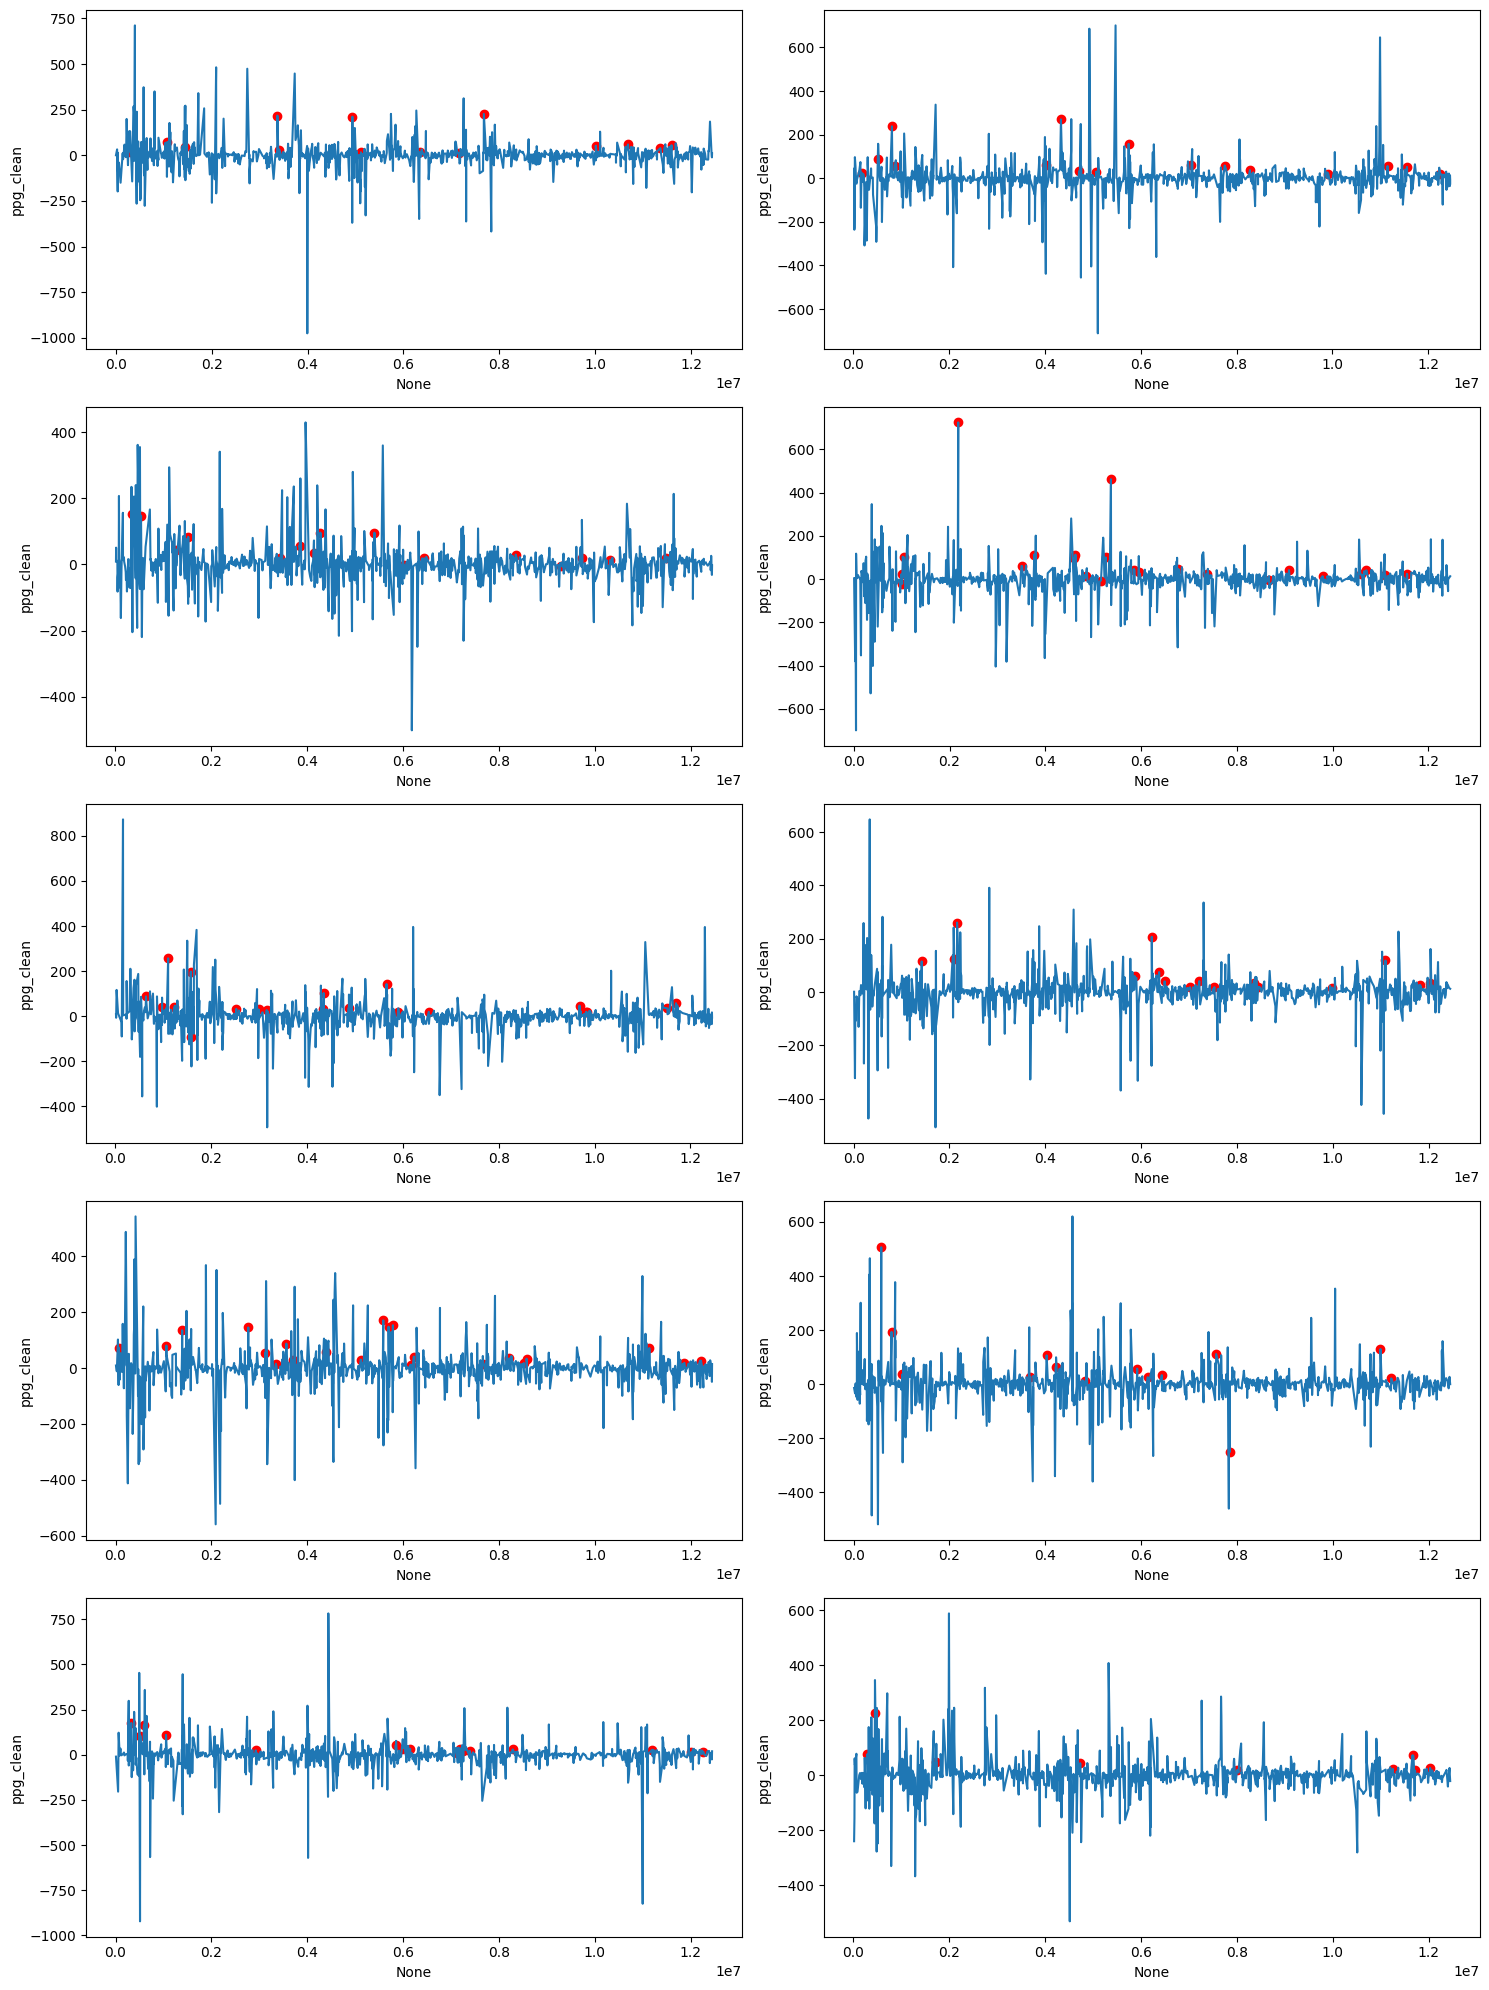

In [44]:
# Create a full array of zeros with the same length as the 'ppg_clean' column
ppg_peaks_binary = np.zeros(len(ppg_df['ppg_clean']))

# Add 1's to the array of zeros for the indexes mentioned in the 'ppg_peaks_corrected' array
ppg_peaks_binary[ppg_peaks_corrected] = 1

# Create a figure and axes for the facet grid
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

# Flatten the axes array
axs = axs.flatten()

# For each subplot
for i in range(10):
    # Grab a random subset of 2500 samples
    subset_indices = np.random.choice(ppg_df.index, 1000, replace=False)
    ppg_df_subset = ppg_df.loc[subset_indices]
    ppg_peaks_binary_subset = ppg_peaks_binary[subset_indices]

    # Create a line plot for 'ppg_clean'
    sns.lineplot(data=ppg_df_subset, x=ppg_df_subset.index, y='ppg_clean', ax=axs[i])

    # Get the indices where ppg_peaks_binary_subset is 1
    peak_indices = np.where(ppg_peaks_binary_subset == 1)[0]

    # Add scatter plot for the peaks
    axs[i].scatter(x=ppg_df_subset.index[peak_indices], y=ppg_df_subset['ppg_clean'].iloc[peak_indices], color='red', label='PPG Peaks')

plt.tight_layout()
plt.show()

/Users/koenraijer/Documents/00 Werk en studie/Msc Data Science & Society/Thesis/.conda/lib/python3.11/site-packages/heartpy/visualizeutils.py:119: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


bpm: 51.923569
ibi: 1155.544602
sdnn: 189.935461
sdsd: 118.799151
rmssd: 150.946657
pnn20: 0.766608
pnn50: 0.504371
hr_mad: 93.750000
sd1: 106.091626
sd2: 157.992059
s: 52658.227789
sd1/sd2: 0.671500
breathingrate: 0.211900


<Figure size 1200x400 with 0 Axes>

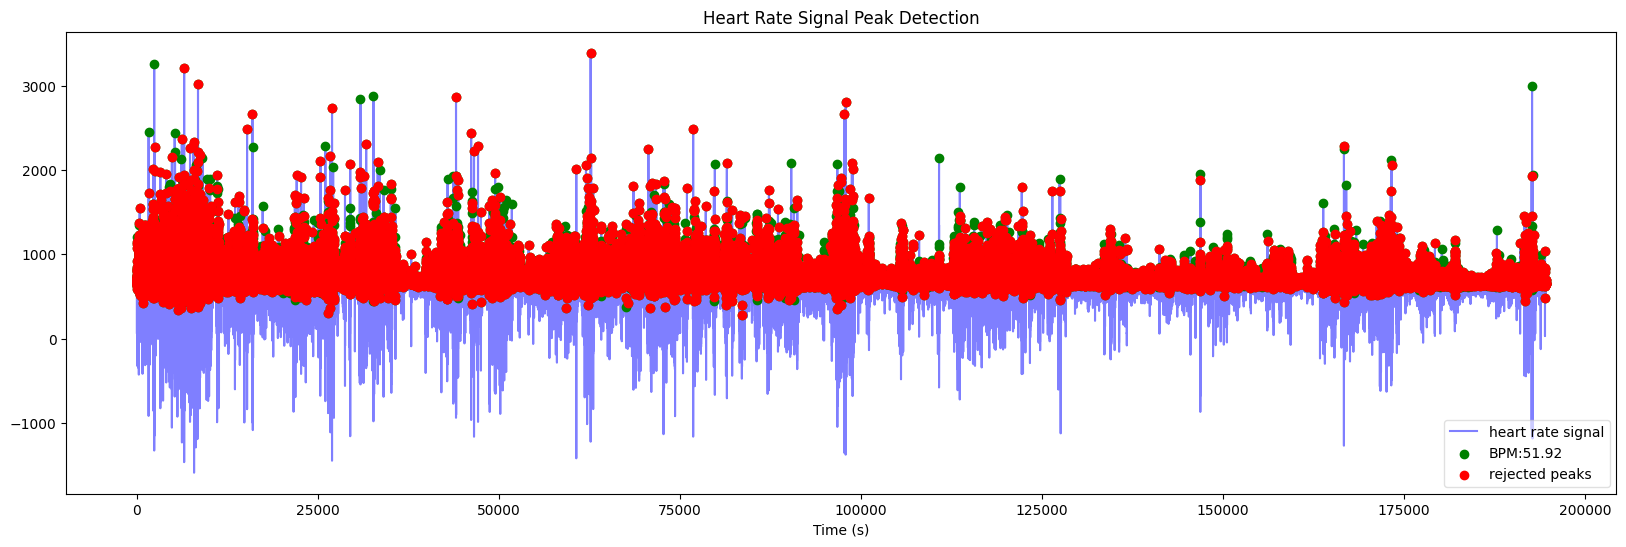

In [50]:
ppg = np.array(ppg)

wd, m = hp.process(ppg, 64.0)

#set large figure
plt.figure(figsize=(12,4))

#call plotter
hp.plotter(wd, m)

#display measures computed
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))
